In [1]:
import json
import pandas as pd
import re
import nltk
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
"""
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
"""
nltk.data.path.append('./nltk_data')

In [2]:
with open('result.json', encoding='utf8') as f:
    data = json.load(f)

In [3]:
def get_msg_df(df):
    msg_df = df[df['type']=='message'].filter(items = ['id','date','from','text','from_id']).reset_index(drop=True)
    tmp_msg_df = []
    for index, row in msg_df.iterrows():
        if type(row['text']) == list:
            s = ''
            for item in row['text']:
                if type(item) == str:
                    s += item
                elif item['type'] != 'link':
                    s += item['text']
            row['text'] = s
        s = ''
        for c in row['text']:
            c = c.lower()
            if c.isalpha() or c.isdigit() or c == "'":
                s += c
            elif c == '?':
                s += ' '+c+' '
            else:
                s += ' '
        row['text'] = ' '.join(s.split())
        tmp_msg_df.append(row)

    tmp_msg_df = pd.DataFrame(tmp_msg_df).reset_index(drop=True)
    msg_df['clean_text'] = tmp_msg_df['text']
    msg_df = msg_df[msg_df['clean_text'] != ''].reset_index(drop=True)
    return msg_df

In [4]:
def get2_msg_df(df):

    def preprocessing_msg_df(msg_df):
        new_msg_df = []
        for index, row in msg_df.iterrows():
            if type(row['text']) == list:
                s = ''
                for item in row['text']:
                    if type(item) == str:
                        s += item
                    else:
                        s += item['text']
                row['text'] = s
            if row['text'] != '':
                new_msg_df.append(row)
        new_msg_df = pd.DataFrame(new_msg_df).reset_index(drop=True)
        return new_msg_df

    def cleaning_msg_df(msg_df):
        msg_df['clean_text'] = msg_df['text'].str.lower()
        msg_df['clean_text'] = msg_df['clean_text'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http+?", "", elem))  
        return msg_df
    
    msg_df = df[df['type']=='message'].filter(items = ['id','date','from','text','from_id']).reset_index(drop=True)
    msg_df = preprocessing_msg_df(msg_df)
    msg_df = cleaning_msg_df(msg_df)
    msg_df = msg_df[msg_df['clean_text'] != ''].reset_index(drop=True)
    return msg_df

In [5]:
df = pd.DataFrame(data['messages'])
msg_df = get2_msg_df(df)

In [6]:
stop = stopwords.words('english')
msg_df['stopped_text'] = msg_df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [7]:
msg_df['token_text'] = msg_df['stopped_text'].apply(lambda x: word_tokenize(x))

In [8]:
def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text
msg_df['stem_text'] = msg_df['token_text'].apply(lambda x: word_stemmer(x))

In [9]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
msg_df['lemma_text'] = msg_df['token_text'].apply(lambda x: word_lemmatizer(x))

In [10]:
def word_pos_tagger(text):
    pos_tagged_text = nltk.pos_tag(text)
    return pos_tagged_text
msg_df['pos_text'] = msg_df['token_text'].apply(lambda x: word_pos_tagger(x))

In [11]:
msg_df['unstopped_token_text'] = msg_df['text'].apply(lambda x: word_tokenize(x.lower()))
msg_df['unstopped_pos_text'] = msg_df['unstopped_token_text'].apply(lambda x: word_pos_tagger(x))

In [12]:
msg_df['unstopped_blob_text'] = msg_df['text'].apply(lambda x: TextBlob(x).tags)

In [13]:
def process_week(msg_df):
    sid = SentimentIntensityAnalyzer()
    d = {
    'compound': 0,
    'neg': 0,
    'neu': 0,
    'pos': 0
    }
    c=0
    for _, row in msg_df.iterrows():
        sentence = row["stopped_text"]
        if sentence != '':
            c+=1
            ss = sid.polarity_scores(sentence)
            for k in ss:
                d[k] += ss[k]
        
    for k in d:
        d[k] = d[k]/c

    pos = d['pos']/(d['pos']+d['neg'])
    neg = 1-pos
    d['fullpos'] = pos
    d['fullneg'] = neg
    return d

In [14]:
from datetime import datetime
from datetime import timedelta

today = datetime.now().replace(microsecond=0)
idx = (today.weekday()+1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
sun = today - timedelta(idx)
stop = sun.replace(hour=23, minute=59, second=59)
start = stop - timedelta(7)
xlabel = (start + timedelta(0,1)).date()

plotinfo = {
    'compound': [],
    'neg': [],
    'neu': [],
    'pos': [],
    'fullpos': [],
    'fullneg': [],
    'countmess': [],
    'countacc': [],
    'msgaccratio': [],
    'xlabel': []
}

while True:
    tmp_df = msg_df[(msg_df['date']>start.isoformat()) & (msg_df['date']<=stop.isoformat())]
    if tmp_df.shape[0] == 0:
        break
    countmess = tmp_df.shape[0]
    countacc = tmp_df['from'].drop_duplicates(keep='last').shape[0]
    d = process_week(tmp_df)
    plotinfo['compound'].insert(0,d['compound'])
    plotinfo['neg'].insert(0,d['neg'])
    plotinfo['neu'].insert(0,d['neu'])
    plotinfo['pos'].insert(0,d['pos'])
    plotinfo['fullpos'].insert(0,d['fullpos'])
    plotinfo['fullneg'].insert(0,d['fullneg'])
    plotinfo['countmess'].insert(0,countmess)
    plotinfo['countacc'].insert(0,countacc)
    plotinfo['msgaccratio'].insert(0,countmess/countacc)
    plotinfo['xlabel'].insert(0,xlabel.isoformat())
    start, stop = start - timedelta(7), stop - timedelta(7)
    xlabel = (start + timedelta(0,1)).date()


In [15]:
import matplotlib.pyplot as plt

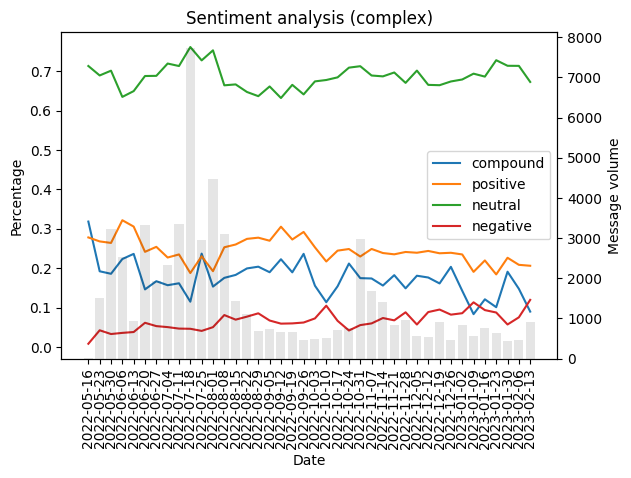

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(plotinfo['compound'], label='compound')
ax1.plot(plotinfo['pos'], label='positive')
ax1.plot(plotinfo['neu'], label='neutral')
ax1.plot(plotinfo['neg'], label='negative')
ax1.legend()
ax2.bar(plotinfo['xlabel'], plotinfo['countmess'], label='message', color=(0, 0, 0, 0.1))

ax1.set_xlabel("Date")
ax1.set_ylabel("Percentage")
ax2.set_ylabel("Message volume")


fig.autofmt_xdate(rotation=90, ha='center')
plt.title('Sentiment analysis (complex)')
plt.savefig('SentimentAnalysisComplex.png')
plt.show()
plt.close()

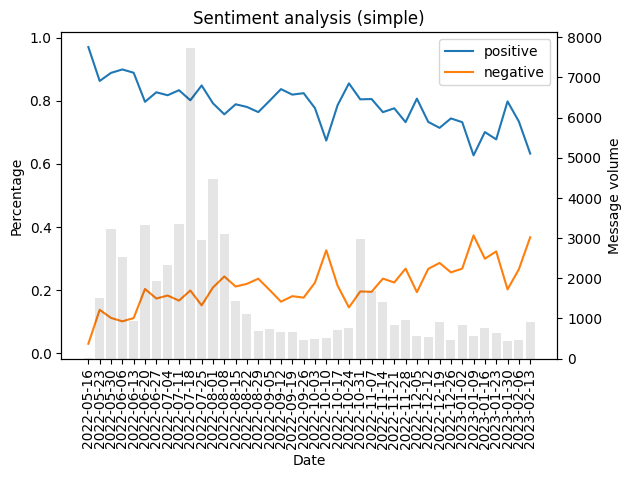

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(plotinfo['fullpos'], label='positive')
ax1.plot(plotinfo['fullneg'], label='negative')
ax1.legend()
ax2.bar(plotinfo['xlabel'], plotinfo['countmess'], label='message', color=(0, 0, 0, 0.1))

ax1.set_xlabel("Date")
ax1.set_ylabel("Percentage")
ax2.set_ylabel("Message volume")


fig.autofmt_xdate(rotation=90, ha='center')
plt.title('Sentiment analysis (simple)')
plt.savefig('SentimentAnalysisSimple.png')
plt.show()
plt.close()

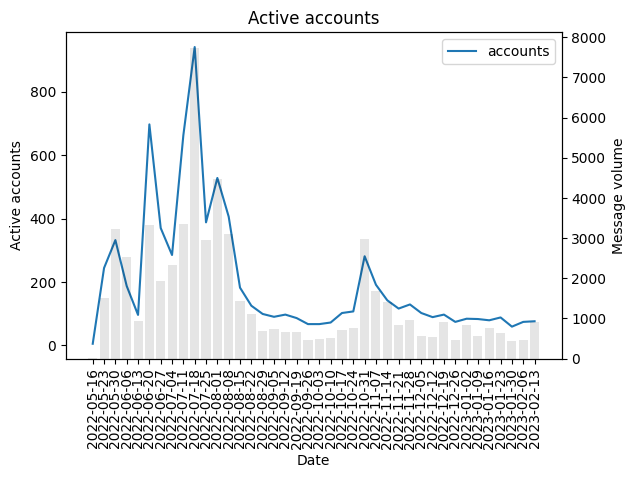

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(plotinfo['countacc'], label='accounts')
ax1.legend()
ax2.bar(plotinfo['xlabel'], plotinfo['countmess'], label='message', color=(0, 0, 0, 0.1))

ax1.set_xlabel("Date")
ax1.set_ylabel("Active accounts")
ax2.set_ylabel("Message volume")

fig.autofmt_xdate(rotation=90, ha='center')
plt.title('Active accounts')
plt.savefig('ActiveAccounts.png')
plt.show()
plt.close()

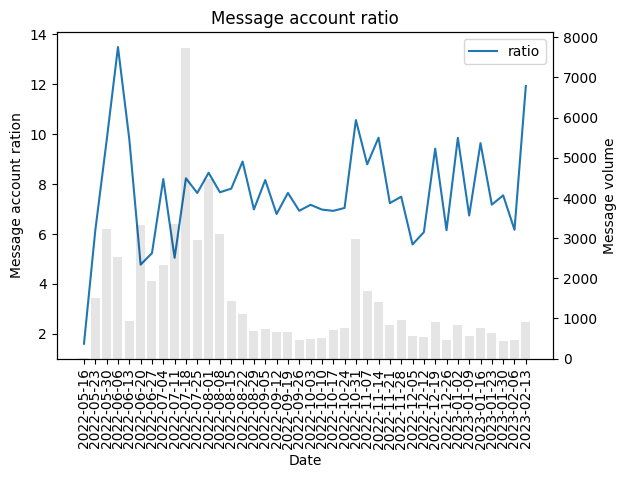

In [19]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(plotinfo['msgaccratio'], label='ratio')
ax1.legend()
ax2.bar(plotinfo['xlabel'], plotinfo['countmess'], label='message', color=(0, 0, 0, 0.1))

ax1.set_xlabel("Date")
ax1.set_ylabel("Message account ration")
ax2.set_ylabel("Message volume")


fig.autofmt_xdate(rotation=90, ha='center')
plt.title('Message account ratio')
plt.savefig('MessageAccountRatio.png')
plt.show()
plt.close()

In [20]:
acc_df = msg_df.groupby('from_id', as_index=False).aggregate(list)

In [21]:
acc_d = {}
for index_r, row in acc_df.iterrows():
    acc_d[index_r] = {}
    for index_c, cell in row.items():
        acc_d[index_r][index_c] = cell

msg_d = {}
for index_r, row in msg_df.iterrows():
    msg_d[index_r] = {}
    for index_c, cell in row.items():
        msg_d[index_r][index_c] = cell

In [22]:
with open('acc_d.json', 'w') as f:
    json.dump(acc_d, f, indent=4)
with open('msg_d.json', 'w') as f:
    json.dump(msg_d, f, indent=4)